# CSCN8010 - Lab 3
Erica Holden, 5490685

## Loading the Data

Initially we load the dogs vs cats data, it has been obtained from Kaggle but there are 25,000 images. For our purposes we will only use 5,000.

In [2]:
import os, shutil
from pathlib import Path

original_dir = Path(".") / "data" / "dogs_vs_cats" / "train"
new_base_dir = Path(".") / "data" / "dogs_vs_cats_small"

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            src = original_dir / fname
            dst = dir / fname
            print("Copying:", src, "->", dst)
            if not src.exists():
                print("⚠️ Source file not found:", src)
            else:
                shutil.copyfile(src=src, dst=dst)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

Copying: data\dogs_vs_cats\train\cat.0.jpg -> data\dogs_vs_cats_small\train\cat\cat.0.jpg
Copying: data\dogs_vs_cats\train\cat.1.jpg -> data\dogs_vs_cats_small\train\cat\cat.1.jpg
Copying: data\dogs_vs_cats\train\cat.2.jpg -> data\dogs_vs_cats_small\train\cat\cat.2.jpg
Copying: data\dogs_vs_cats\train\cat.3.jpg -> data\dogs_vs_cats_small\train\cat\cat.3.jpg
Copying: data\dogs_vs_cats\train\cat.4.jpg -> data\dogs_vs_cats_small\train\cat\cat.4.jpg
Copying: data\dogs_vs_cats\train\cat.5.jpg -> data\dogs_vs_cats_small\train\cat\cat.5.jpg
Copying: data\dogs_vs_cats\train\cat.6.jpg -> data\dogs_vs_cats_small\train\cat\cat.6.jpg
Copying: data\dogs_vs_cats\train\cat.7.jpg -> data\dogs_vs_cats_small\train\cat\cat.7.jpg
Copying: data\dogs_vs_cats\train\cat.8.jpg -> data\dogs_vs_cats_small\train\cat\cat.8.jpg
Copying: data\dogs_vs_cats\train\cat.9.jpg -> data\dogs_vs_cats_small\train\cat\cat.9.jpg
Copying: data\dogs_vs_cats\train\cat.10.jpg -> data\dogs_vs_cats_small\train\cat\cat.10.jpg
Copying:

## Checking for bad images

We want to check that there are no corrupted images in the dataset, using the code below.

In [3]:
from PIL import Image
from pathlib import Path

bad_files = []
for file in Path(new_base_dir).rglob("*.jpg"):
    try:
        with Image.open(file) as img:
            img.load()  # force loading pixel data
    except Exception as e:
        bad_files.append((file, str(e)))

print(f"Found {len(bad_files)} problematic images.")
for file, error in bad_files[:5]:  # Show just first 5 errors
    print(f"{file}: {error}")


Found 0 problematic images.


## Checking for grayscale images

Above we can see there are 0 problematic images, but what if some are grayscale? We want to check if any of the images are grayscale instead of RGB, using the code below.

In [4]:
from collections import Counter
channels = []

for file in new_base_dir.rglob("*.jpg"):
    with Image.open(file) as img:
        channels.append(len(img.getbands()))  # 1 = grayscale, 3 = RGB

print("Channel counts:", Counter(channels))

Channel counts: Counter({3: 5000})


## Class distribution bar plot

As above, all the images have 3 channels - RGB - and are not grayscale, making them equivalent. Let's explore the distribution of cat and dog images in the training set, using a bar plot.

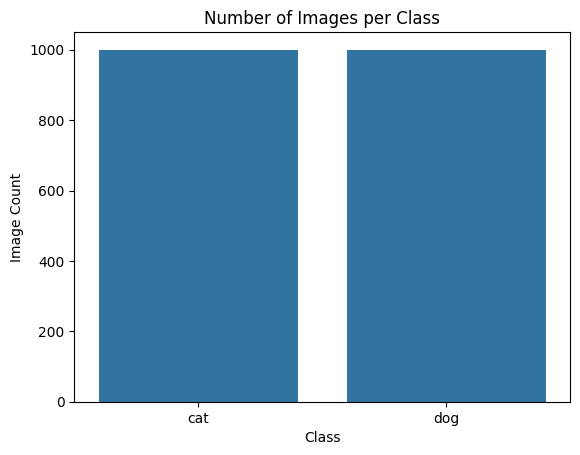

In [5]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

base_dir = new_base_dir / "train"

class_counts = {}
for folder in base_dir.iterdir():
    if folder.is_dir():
        # Count all jpg, jpeg, and png files in the folder
        image_files = list(folder.glob("*.jpg")) + list(folder.glob("*.jpeg")) + list(folder.glob("*.png"))
        class_counts[folder.name] = len(image_files)

df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])

sns.barplot(data=df, x="Class", y="Count")
plt.title("Number of Images per Class")
plt.ylabel("Image Count")
plt.xlabel("Class")
plt.show()


## Loading the datasets for Tensorflow

Now we can load the datasets for Tensorflow

In [5]:
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory

data_folder = pathlib.Path('./data/dogs_vs_cats_small')

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


## Build a custom convolutional neural network from scratch using Keras

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

## Configure the model for training

In [12]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

## Train and save the model

In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 433ms/step - accuracy: 0.5302 - loss: 0.7670 - val_accuracy: 0.5020 - val_loss: 0.6928
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 454ms/step - accuracy: 0.5150 - loss: 0.6941 - val_accuracy: 0.5010 - val_loss: 0.6907
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 430ms/step - accuracy: 0.5311 - loss: 0.6917 - val_accuracy: 0.5550 - val_loss: 0.6786
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 438ms/step - accuracy: 0.5738 - loss: 0.6901 - val_accuracy: 0.5880 - val_loss: 0.6668
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 437ms/step - accuracy: 0.6199 - loss: 0.6477 - val_accuracy: 0.6130 - val_loss: 0.6388
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 439ms/step - accuracy: 0.6814 - loss: 0.6020 - val_accuracy: 0.6960 - val_loss: 0.5880
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 433ms/step - accuracy: 0.6972 - loss: 0.5832 - val_accuracy: 0.6930 - val_loss: 0.5700
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 440ms/step - accuracy: 0.7372 - loss: 0.5355 - val_accu

## Train a VGG16 Model on the same dataset

In [9]:
# Train a VGG16 model pre-trained on ImageNet
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
base_model_vgg16.trainable = False  # Freeze the base model
model_vgg16 = models.Sequential([
    base_model_vgg16,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model_vgg16.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/vgg16_pretrained.keras",
        save_best_only=True,
        monitor="val_loss")
]
history_vgg_pretrained = model_vgg16.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.8750 - loss: 4.9570 - val_accuracy: 0.9320 - val_loss: 1.9714
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9688 - loss: 0.6757 - val_accuracy: 0.9410 - val_loss: 1.6755
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9944 - loss: 0.0672 - val_accuracy: 0.9350 - val_loss: 2.2599
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9908 - loss: 0.1548 - val_accuracy: 0.9240 - val_loss: 2.9942
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9926 - loss: 0.2028 - val_accuracy: 0.9490 - val_loss: 1.6308
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9945 - loss: 0.0558 - val_accuracy: 0.9510 - val_loss: 1.6238
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9995 - loss: 0.0021 - val_accuracy: 0.9480 - val_loss: 2.1174
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accurac

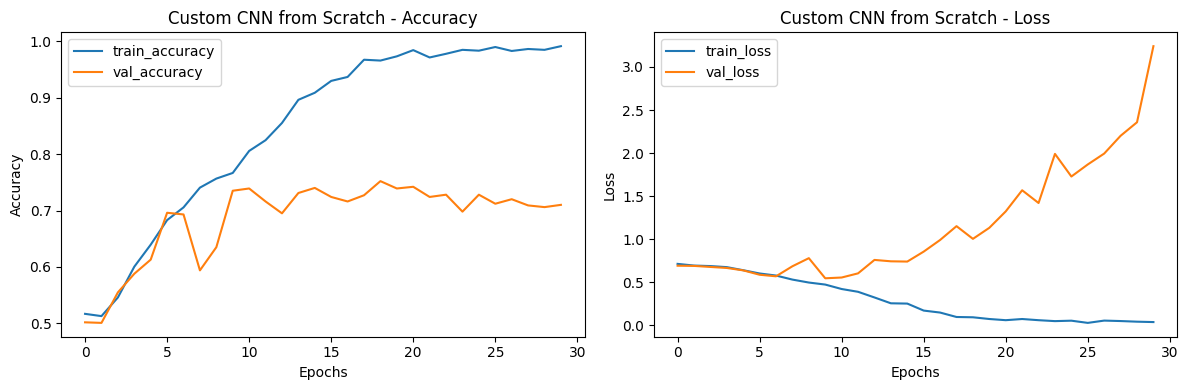

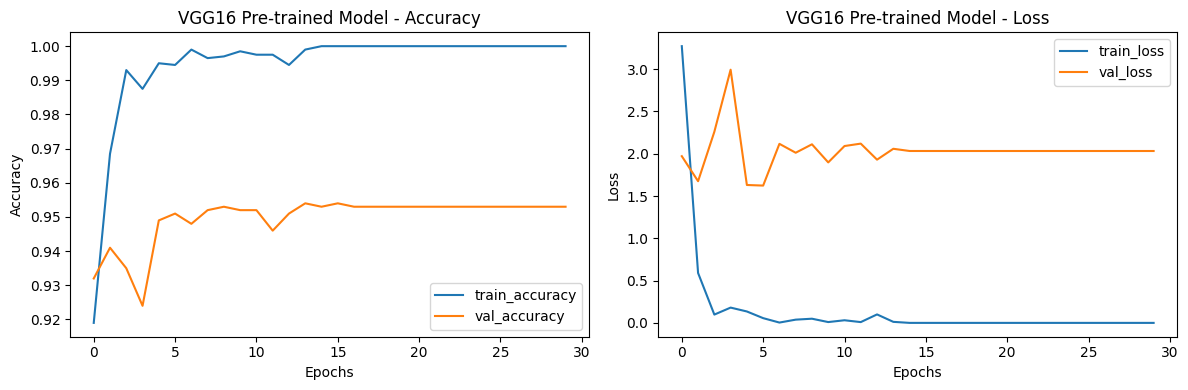

In [14]:
# Display the accuracy and loss curves for both models
import matplotlib.pyplot as plt
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history, "Custom CNN from Scratch")
plot_history(history_vgg_pretrained, "VGG16 Pre-trained Model")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

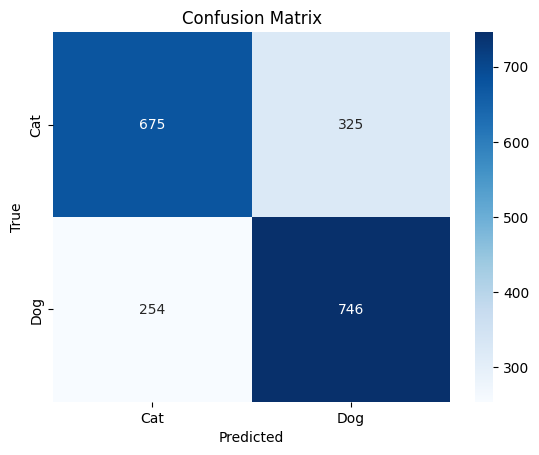

Classification Report:
               precision    recall  f1-score   support

         Cat       0.73      0.68      0.70      1000
         Dog       0.70      0.75      0.72      1000

    accuracy                           0.71      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.71      0.71      0.71      2000

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1

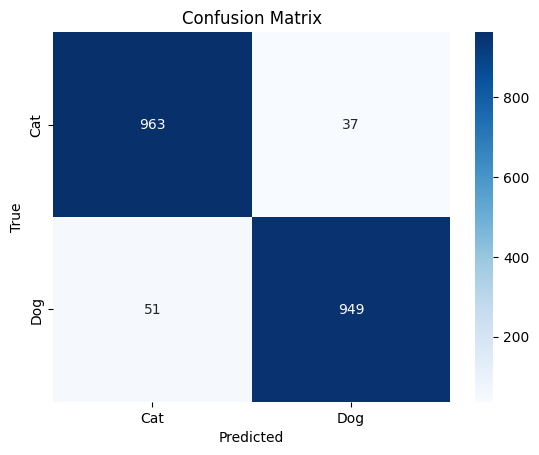

Classification Report:
               precision    recall  f1-score   support

         Cat       0.95      0.96      0.96      1000
         Dog       0.96      0.95      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In [ ]:
# Display the confusion metric, precision, recall, and F1 score for the custom CNN and for the VGG16 pre-trained model
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

def evaluate_model(model, dataset):
    y_true = []
    y_pred = []
    
    for images, labels in dataset:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend((predictions > 0.5).astype(int).flatten())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=['Cat', 'Dog'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    print("Classification Report:\n", report)

saved_model_path = "./models/convnet_from_scratch.keras"
model = keras.models.load_model(saved_model_path)

saved_model_path_vgg16 = "./models/vgg16_pretrained.keras"
model_vgg16 = keras.models.load_model(saved_model_path_vgg16)

evaluate_model(model, test_dataset)
evaluate_model(model_vgg16, test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

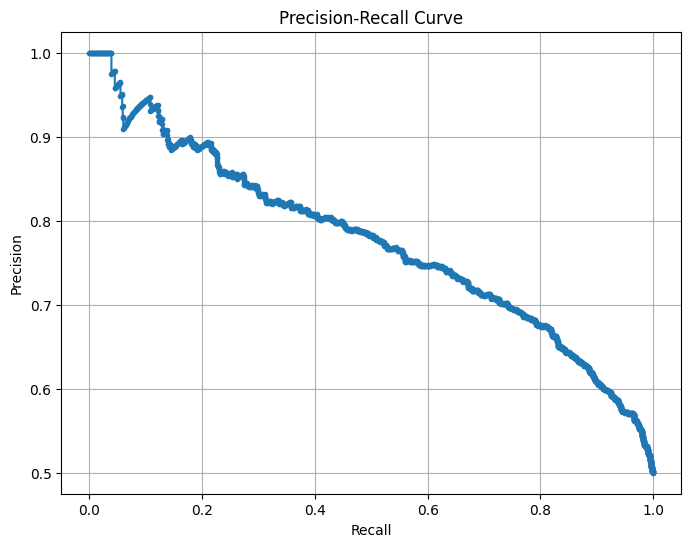

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

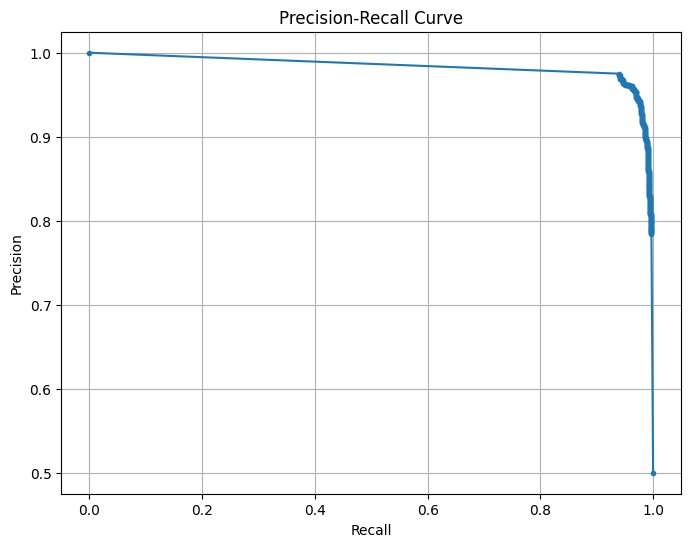

In [18]:
# Plot a precision-recall curve for the custom CNN and the VGG16 pre-trained model
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(model, dataset):
    y_true = []
    y_scores = []
    
    for images, labels in dataset:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_scores.extend(predictions.flatten())
    
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid()
    plt.show()

plot_precision_recall_curve(model, test_dataset)
plot_precision_recall_curve(model_vgg16, test_dataset)

## Conclusions

We can see that the VGG16 model that was pretrained on ImageNet performed much better. The precision was 95% and 96%, recall was 95% and 96%, and f1 score was 96% for both cats and dogs. On the other hand, the CNN had a precision of 73% and 70%, recall of 68% and 75%, and f1 scores of 70% and 72%. The accuracy for the VGG16 model was 96% whereas for the CNN it was only 71%. 

The confusion matrices similarly show very few misclassifications for the VGG16 model with more for the CNN model.

A curve closer to the top right corner in the precision-recall curve plots mean the model achieves higher precision and higher recall at the same time, which is preferred. Here we see again that the curve looks better for the VGG16 model than the CNN model.
